In [23]:
# Importing necessary libraries 
import sys
import numpy as np
import emcee
import astropy.io.fits as pyfits
import matplotlib.pylab as pl
import random,os
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
from astropy.io import ascii
import corner
from astropy.table import Column, join


In [24]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
os.environ["OMP_NUM_THREADS"] = "1"

12 CPUs


In [25]:
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

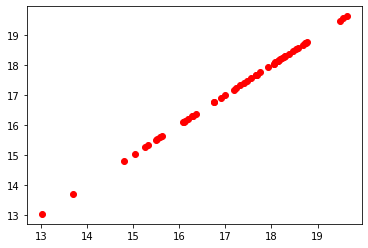

In [88]:
#data  BgVriY
file1 = 'Gen3_B.csv' # change the filaname here if needed for other bands or for other calibrators
tab1 = ascii.read('../data/working/'+file1,header_start=0)

file2 = 'B_sbfj21_update3.csv' # change the filaname here if needed for other bands or for other calibrators
tab2 = ascii.read('../data/working/'+file2)


new = join(tab1,tab2,keys='sn')

pl.plot(new['Mmax_1'], new['Mmax_2'], 'ro')

# Result
w1 = np.where((tab1['st']<0.75)  & (tab1['EBVmw']<0.15) & (tab1['zcmb']>0.01))
w2 = np.where((tab2['st']<0.75)  & (tab2['EBVmw']<0.15) & (tab2['zcmb']>0.01))


In [65]:
c = 300000.
q=-0.53

In [66]:
#tab = ascii.read('../data/working/'+file)
st = tab['st']
est = tab['est']
zhel = tab['zhel']
zcmb = tab['zcmb']
mmax = tab['Mmax']
emmax = tab['eMmax']
bv = tab['BV']
ebv = tab['eBV']
m_csp = tab['m']
eml = (tab['m']-tab['ml'])
emu = (tab['mu']-tab['m'])
em = (emu+eml)/2.
dist = tab['dist']
edist = tab['edist']
c_ms = tab['covMs']
c_mbv = tab['covBV_M']
sn = tab['sn']
ebv_host = tab['EBVmw']



In [ ]:
#Selection

w0 = np.where((tab['st']<0.75)  & (tab['EBVmw']<0.15) & (tab['zcmb']>0.01))

print(sn[w0])


In [ ]:
# Eqn 9 of Bruns 2018
def distmod(h,z1,z2):
    t1 = (1+z1)/(1+z2)
    t2 = (c*z2)/h
    t3 = 1 + (((1-q)/2)*z2)
    return (5*np.log10(t1*t2*t3)) +25


In [ ]:
# Liklihood function
def like(par):
    p,p1,p2,sig,h0 = par

    mu_obs=[]
    mu_model=[]
    mu_stat=[]
    
    if  -25.0<p<14.0  and -100.0<p1<100.0 and -100.0<p2<100.0 and  0.<sig<1. and 0< h0 < 1000.0: # priors
        

        
        mu_sn = mmax[w0] - p - p1*(st[w0] - 0.5) -  p2*(st[w0] - 0.5)**2

        mu_cal = mmax[w1] - p - p1*(st[w1] - 0.5) -  p2*(st[w1] - 0.5)**2 
        
        for mu_sn in mu_sn:
            mu_obs.append(mu_sn)
        for mu_cal in mu_cal:
            mu_obs.append(mu_cal)
        mu_model_sn = distmod(h0,zhel[w0],zcmb[w0])
        mu_model_cal = dist[w1]
        for mu_model_sn in mu_model_sn:
            mu_model.append(mu_model_sn)
        for mu_model_cal in mu_model_cal:
            mu_model.append(mu_model_cal)
        
        fac= (p1+(2*p2*st[w0]))
        fac1= (p1+(2*p2*st[w1]))
        
        #velterm = (2.17*437.0)**2/(c*zcmb)**2
        vel = 300

        err = (fac*est[w0])**2 +emmax[w0]**2 + 2*fac*c_ms[w0]+sig**2+(0.00000723*vel/zcmb[w0])**2
        err1 = ((fac1*est[w1])**2) +(emmax[w1]**2) +(2*fac1*c_ms[w1])+sig**2+(edist[w1]**2)

        for err in err:
            mu_stat.append(err)
        for err1 in err1:
            mu_stat.append(err1)
        mu_stat=np.sqrt(mu_stat)

        mu_obs = np.array(mu_obs)
        mu_model = np.array(mu_model)
        mu_stat = np.array(mu_stat)
        dmu=mu_obs-mu_model
        
        chi =np.sum((dmu)**2/mu_stat**2)
        return -0.5*chi - (0.5*np.sum(np.log(2*np.pi*(mu_stat)**2))) 
    else:
        return -np.inf

In [ ]:
#initial guess
plim=-17, -20
p1lim =-10,20
p2lim = -20,20

siglim=0,1
h0lim= 50.0,100

# EMCEE
ndim, nwalkers = 5, 50
ssize=1000
burnin = 500


p00 = np.random.rand(nwalkers) * (plim[1] - plim[0]) + plim[0]
p10 = np.random.rand(nwalkers) * (p1lim[1] - p1lim[0]) + p1lim[0]
p20 = np.random.rand(nwalkers) * (p2lim[1] - p2lim[0]) + p2lim[0]
sig0 = np.random.rand(nwalkers) * (siglim[1] - siglim[0]) + siglim[0]
h00 = np.random.rand(nwalkers) * (h0lim[1] - h0lim[0]) + h0lim[0]

#p0 = zip(*[p00,p10,p20,rv0,alpha0,sig0,vel0,h00])
p0 = np.array([p00,p10,p20,sig0,h00]).T


In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, like)
print ("running mcmc on "+file)
start = time.time()
sampler.run_mcmc(p0,ssize,progress=True)
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
end = time.time()
serial_time = end - start
print ("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

In [ ]:
# Chains
fig, axes = pl.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$M_B$",r"P1", r"P2",r"$\sigma_{int}$", r"$H_0$"]
for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

fig.savefig("/Users/suddin/Desktop/"+file[:-4]+"_chains.pdf")

In [ ]:
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
#tau = sampler.get_autocorr_time()
#print(tau)

 # Printing results
for i, name in enumerate(labels):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{name}: {mcmc[1]:.3f} (+{q[1]:.3f}/-{q[0]:.3f})")
    
    


In [ ]:
# Triangle plot

figure = corner.corner(samples, labels = ["$M_B$","P1", "P2",r"$\sigma_{int}$", r"$H_0$"])
figure.savefig("/Users/suddin/Desktop/"+file[:-4]+"_5par_cutShuvo"+str(nwalkers)+"_"+str(ssize)+".pdf")
